In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch as t
import torch.nn as nn
import torch.nn.functional as F

from IPython import display
import time

from math import *

from torchvision.transforms.functional import rotate

import pygame

DEVICE = "cuda"

pygame 2.1.2 (SDL 2.0.16, Python 3.10.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [13]:
NUM_AGENTS = 1000
NUM_STATES = 3
NUM_PERCEPTIONS = 3
NUM_ACTIONS = 2
RES = 512

def to_plt(img, detach=True): 
    return img.squeeze(0).permute(1, 2, 0).detach().cpu().numpy() if detach \
        else img.squeeze(0).permute(1, 2, 0).cpu().numpy()


class RadConv(nn.Module):
    def __init__(self, NI, NO, radius):
        super().__init__()
        self.conv = nn.Conv2d(NI, NO, 2*radius+1, padding=radius, padding_mode='circular', bias=None)
        
        avg_weight = t.zeros_like(self.conv.weight.data)
        
        for theta in np.arange(0,2*pi,pi/64.0):
            avg_weight += rotate(self.conv.weight.data.detach().clone(), 180*theta/pi)/128.0
        # for theta in np.arange(0,2*t.pi,t.pi/256.0):
        #     avg_weight += rotate(self.conv.weight.data.detach().clone(), 180*theta/t.pi)/np.sqrt(512.0)
                    
        self.conv.weight.data = np.pi*avg_weight
    
    def forward(self, x):
        return self.conv(x)
        
class SimpleConvNet(nn.Module):
    def __init__(self, NI, NO = 1, radius=3):

        super().__init__()
        
        self.conv = RadConv(NI, NO, radius)
        # self.conv = nn.Conv2d(NI, NO, 2*radius+1, padding=radius, padding_mode='circular', bias=None)
        self.relu = nn.ReLU()
        self.thresh = nn.Threshold(0.5, 0)
        self.sigmoid = nn.Sigmoid()
        self.glu = nn.GLU()
        

    def forward(self, x):
        x = self.conv(x)
        # x = self.relu(x)
        # x = self.sigmoid(x)
        # x = self.thresh(x)
        # x = t.clamp(x, 0, 1)
        x = t.heaviside((x - 0.5*t.min(x)), t.cuda.FloatTensor([0]))
        return x        

torch.Size([1, 512, 512])


tensor([[[[0, 1, 1,  ..., 0, 0, 0],
          [1, 0, 1,  ..., 1, 1, 0],
          [0, 0, 1,  ..., 0, 1, 1],
          ...,
          [1, 0, 0,  ..., 0, 1, 1],
          [0, 1, 1,  ..., 1, 1, 0],
          [0, 1, 0,  ..., 1, 1, 0]]]], device='cuda:0')

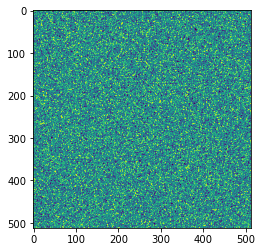

In [14]:
positions = t.randint(2, (1, 1, RES, RES)).cuda(); print(positions[0:1, :, :, :].squeeze(0).shape)
plt.imshow(to_plt(positions[0:1, :, :, :]))
# positions = t.rand((1, RES, RES, 3)).cuda(); print(positions.shape); print(positions.squeeze(0).shape)
# plt.imshow(positions.squeeze(0)[:,:,0].cpu().numpy())
positions

In [15]:
positions = t.randint(RES, (NUM_AGENTS, 2)).cuda()
directions = t.randint(2, (NUM_AGENTS, 2)).cuda()
speeds = t.randint(RES//128, (NUM_AGENTS, 1)).cuda()
states = t.randint(NUM_STATES, (NUM_AGENTS, 1)).cuda()
perceptions = t.rand((NUM_AGENTS, NUM_PERCEPTIONS)).cuda()
# positions, directions, speeds, states, perceptions

In [16]:
world = t.zeros((1, 3, RES, RES), dtype=t.long).cuda()
world[0, 1, 10, 10] = 255

In [17]:
world[0, 1, 10, 10]

tensor(255, device='cuda:0')

In [18]:
world = t.zeros((1, 3, RES, RES), dtype=t.long).cuda()
for i in range(NUM_AGENTS):
    state = states[i].cpu().numpy()[0]
    x_i = positions[i, 0].cpu().numpy()
    y_i = positions[i, 1].cpu().numpy()
    print(x_i, y_i, state)
    world[0, state, x_i, y_i] = 255
    # world[0, 1, positions[i, 0], positions[i, 1]] = directions[i, 0]
    # world[0, 2, positions[i, 0], positions[i, 1]] = directions[i, 1]


506 33 1
113 108 1
21 342 2
80 386 0
433 480 2
348 120 2
266 257 0
12 364 1
382 317 2
414 366 2
291 377 2
478 311 0
80 31 0
337 453 1
490 241 1
286 312 2
307 230 2
288 277 2
212 456 1
312 117 1
188 402 1
118 299 2
234 46 1
87 435 2
113 415 1
42 233 2
18 433 2
13 353 2
99 318 0
287 250 0
326 404 1
392 397 2
227 498 1
402 78 2
292 187 0
73 24 2
295 434 0
103 310 1
18 31 2
389 454 2
109 321 1
217 500 1
456 419 2
386 409 2
153 64 2
353 488 2
377 456 2
312 22 0
305 27 0
86 331 0
425 384 1
91 202 0
300 171 1
165 210 0
504 99 1
120 133 1
338 195 2
352 450 2
61 8 1
50 98 1
0 215 2
50 416 2
124 95 1
270 140 2
186 6 0
450 8 2
30 25 1
98 136 1
43 392 1
305 30 2
361 288 1
258 435 2
402 501 1
378 229 2
335 153 0
378 31 2
207 42 2
272 124 1
349 446 0
170 314 1
350 305 2
491 142 2
382 67 1
362 420 0
52 397 0
209 124 0
481 314 2
312 236 1
121 64 2
33 354 1
453 449 2
505 353 2
14 243 1
193 499 2
275 386 0
238 246 2
508 12 0
370 500 1
236 329 2
461 103 1
221 467 1
279 178 1
63 310 1
63 464 1
320 325 0
3

In [19]:
world[0, 0, 74, 72]    

tensor(0, device='cuda:0')

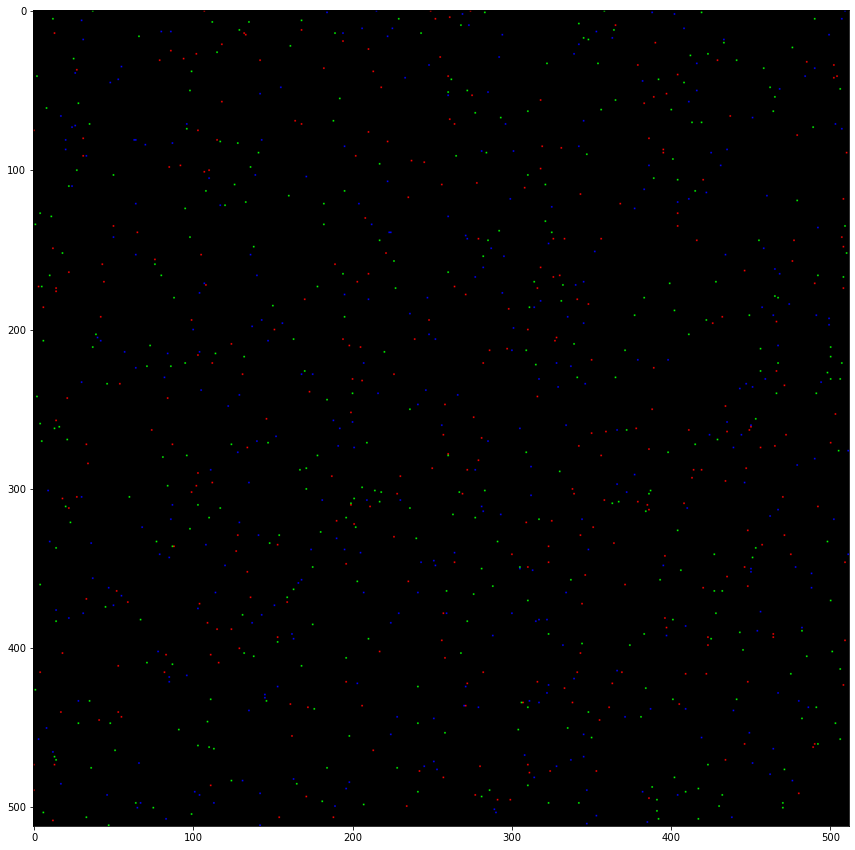

In [35]:
f, axs = plt.subplots(1,figsize=(15,15))
axs.imshow(to_plt(world))

In [11]:
to_plt(world).shape

(512, 512, 3)

In [4]:
radius = 5

class Agent(nn.Module):
    
    def __init__(self, position = t.rand(RES, RES), action = t.rand(size = (1, NUM_ACTIONS)), state = t.rand(1, NUM_STATES), perception = t.rand(1, NUM_PERCEPTIONS)):
        super().__init__()
        
        self.position = position; print(self.position.shape)
        print(position)
        self.action = action; print(self.action.shape)
        self.state = state; print(self.state.shape)
        self.perception = perception; print(self.perception.shape)

        # self.action = action.view(-1, 1); print(self.action.shape)
        # self.state = state.view(-1, 1); print(self.state.shape)
        # self.perception = perception.view(-1, 1); print(self.perception.shape)
        self.config = t.cat([self.perception.view(-1, NUM_PERCEPTIONS), self.state.view(-1, NUM_STATES), self.action.view(-1, NUM_ACTIONS)], dim = 1); print(self.config.shape)
        
        self.percept = RadConv(NI = NUM_PERCEPTIONS+NUM_STATES, NO = NUM_PERCEPTIONS+NUM_STATES, radius = radius) #things in the environment; other agents states, their perception etc; NUM_AGENTS x NUM_STATES x NUM_PERCEPTIONS
        # self.conv = nn.Conv2d(NUM_AGENTS*NUM_PERCEPTIONS*NUM_STATES, NUM_PERCEPTIONS*NUM_STATES, 2*radius+1, padding=radius, padding_mode='circular', bias=None)
        self.fc1 = nn.Linear(NUM_PERCEPTIONS+NUM_STATES, NUM_PERCEPTIONS+NUM_STATES)
        self.fc2 = nn.Linear(NUM_PERCEPTIONS+NUM_STATES, NUM_PERCEPTIONS)
        self.fc3 = nn.Linear(NUM_PERCEPTIONS+NUM_STATES, NUM_STATES)
        self.fc4 = nn.Linear(NUM_PERCEPTIONS+NUM_STATES, NUM_ACTIONS)

    def forward(self, x):
        print(self.state)
        perception, states = F.relu(self.percept(x)) #should be NUM_AGENTS x NUM_STATES x NUM_PERCEPTIONS -> NUM_AGENTS x NUM_STATES x NUM_PERCEPTIONS
        # perception, states = F.relu(self.conv(x))
        print(perception)
        print(states)
        self.perception = F.relu(self.fc1(t.tensor(t.cat([perception, states], dim=0)).view(-1, NUM_PERCEPTIONS+NUM_STATES))); print(self.perception)
        self.perception = F.softmax(self.fc2(self.perception))
        self.state = F.softmax(self.fc3(self.perception).view(-1, NUM_STATES))
        self.action = F.softmax(self.fc4(self.perception).view(-1, NUM_ACTIONS))
        self.config = t.tensor(t.cat([self.perception, self.state, self.action], dim=1))
        return self.config

In [5]:
Agent().config


torch.Size([512, 512])
tensor([[0.6436, 0.1657, 0.0183,  ..., 0.0146, 0.7554, 0.4294],
        [0.8607, 0.8119, 0.4676,  ..., 0.3828, 0.7251, 0.3021],
        [0.7583, 0.6176, 0.8215,  ..., 0.7909, 0.0720, 0.1656],
        ...,
        [0.6884, 0.4218, 0.9399,  ..., 0.4075, 0.6524, 0.0902],
        [0.1690, 0.3186, 0.8907,  ..., 0.1667, 0.2425, 0.9091],
        [0.7027, 0.3399, 0.7627,  ..., 0.4011, 0.8463, 0.0295]])
torch.Size([1, 512])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 518])


TypeError: cos(): argument 'input' (position 1) must be Tensor, not numpy.float64

In [15]:
preys_[0].state

NameError: name 'preys_' is not defined

In [20]:
agents = dict(preys=t.tensor([prey.state for prey in preys_]).view(-1, 1), predators=t.tensor([predator.state for predator in predators]).view(-1, 1))

AttributeError: 'Prey' object has no attribute 'state'

In [130]:
class Environment(nn.Module):
    def __init__(self, spatial_contents, env_state, preys, predators):
        super(Environment, self).__init__()
        self.spatial_contents = spatial_contents
        self.config = env_state
        self.predators = predators
        self.preys = preys
        self.fc1 = nn.Linear((NUM_AGENTS*NUM_ACTIONS*NUM_PERCEPTIONS*NUM_STATES), NUM_AGENTS*NUM_ACTIONS) # env_variables + (positions + action + perceptions) of all agents -> some number
        self.fc2 = nn.Linear((NUM_AGENTS*NUM_ACTIONS*NUM_PERCEPTIONS*NUM_STATES), NUM_AGENTS*NUM_PERCEPTIONS)
        self.fc3 = nn.Linear((NUM_AGENTS*NUM_ACTIONS*NUM_PERCEPTIONS*NUM_STATES), NUM_AGENTS*NUM_STATES)
        # self.fc3 = nn.Linear(128, contents)
    
    def _state(self):
        self.config = t.cat(t.tensor([self.predators, self.preys]))
        return self.config
    
    def __get__(self, x=None):
        x = self._state()
        return self.forward(x)

    def forward(self, x):
        
        # x = t.cat(
        #     [t.tensor(list(self.env_state.values)).view(-1, 1), 
        #     t.flatten(t.tensor([[predator.state, predator.perceptions, predator.actions] for predator in self.predators])).view(-1, 1), 
        #     t.flatten(t.tensor([[prey.state, prey.perceptions, prey.actions] for prey in self.preys]))]).cuda()
        
        x = self.config.view(-1, 1)         
        actions = F.softmax(F.relu(self.fc1(x)).view(NUM_AGENTS, NUM_ACTIONS))
        perceptions = F.softmax(F.relu(self.fc2(x)).view(NUM_AGENTS, NUM_PERCEPTIONS))
        states = F.softmax(F.relu(self.fc2(x)).view(NUM_AGENTS, NUM_STATES))
        return t.cat([actions, perceptions, states]).cuda()

In [142]:
env = Environment(t.tensor([]), t.cat(t.tensor([predators, preys]) ), preys, predators)

Conf = env(env.config)

RuntimeError: Could not infer dtype of Predator

In [118]:
[p.forward() for p in env.predators]

TypeError: Agent.forward() missing 1 required positional argument: 'x'

In [111]:
class Environment(nn.Module):
    def __init__(self, spatial_contents, env_state, agents):
        super(Environment, self).__init__()
        self.spatial_contents = spatial_contents
        self.state = env_state
        self.predators = agents["predators"]
        self.preys = agents["preys"]
        self.fc1 = nn.Linear(len(env_state.values)*(NUM_AGENTS*NUM_ACTIONS*NUM_PERCEPTIONS*NUM_STATES), NUM_AGENTS*NUM_ACTIONS) # env_variables + (positions + action + perceptions) of all agents -> some number
        self.fc2 = nn.Linear(len(env_state.values)*(NUM_AGENTS*NUM_ACTIONS*NUM_PERCEPTIONS*NUM_STATES), NUM_AGENTS*NUM_PERCEPTIONS)
        self.fc3 = nn.Linear(len(env_state.values)*(NUM_AGENTS*NUM_ACTIONS*NUM_PERCEPTIONS*NUM_STATES), NUM_AGENTS*NUM_STATES)
        # self.fc3 = nn.Linear(128, contents)

    def forward(self, x):
        
        x = t.cat(
            [t.tensor(list(self.env_state.values)).view(-1, 1), 
            t.flatten(t.tensor([[predator.state, predator.perceptions, predator.actions] for predator in self.predators])).view(-1, 1), 
            t.flatten(t.tensor([[prey.state, prey.perceptions, prey.actions] for prey in self.preys]))]).cuda()
            
        actions = F.softmax(F.relu(self.fc1(x)).view(NUM_AGENTS, NUM_ACTIONS))
        perceptions = F.softmax(F.relu(self.fc2(x)).view(NUM_AGENTS, NUM_ACTIONS))
        states = F.softmax(F.relu(self.fc2(x)).view(NUM_AGENTS, NUM_ACTIONS))
        return t.cat([actions, perceptions, states])

In [46]:
t.flatten(t.tensor([[predator.state, predator.perceptions, predator.actions] for predator in predators])).view(-1, 1)

NameError: name 'predators' is not defined

In [ ]:
pygame.init()
screen = pygame.display.set_mode((MULT*RES,MULT*RES), 0, 24)
